In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/NLP/taskCTrainingData.csv",encoding='iso-8859-1')

In [ ]:
pre1 =  raw.iloc[:,0:2].copy()
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['source_text']], ignore_index=True)
pre['stance'] = pd.concat([pre1['target_text']],ignore_index = True)

In [ ]:
pre['text'][0]

In [ ]:
import re
def text_strip(column):
    for row in column:
        row=re.sub("(\\t)", ' ', str(row)).lower() 
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        row=re.sub("(__+)", ' ', str(row)).lower()   
        row=re.sub("(--+)", ' ', str(row)).lower()   
        row=re.sub("(~~+)", ' ', str(row)).lower()  
        row=re.sub("(\+\++)", ' ', str(row)).lower()   
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()
        row=re.sub("(mailto:)", ' ', str(row)).lower() 
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower()        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() 
        row=re.sub("(\-\s+)", ' ', str(row)).lower() 
        row=re.sub("(\:\s+)", ' ', str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
        row = re.sub("(\s+)",' ',str(row)).lower() 
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower()  
        yield row

In [ ]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['stance'])

In [ ]:
!pip install spacy

In [ ]:
from time import time
import spacy
nlp = spacy.load("en_core_web_sm", disable=['ner','parser'])
t = time()
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=500)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()
stance = [str(doc) for doc in nlp.pipe(brief_cleaning2, batch_size=500)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_stance'] = pd.Series(stance)

In [ ]:
pre

In [ ]:

cnt=0
for i in pre['cleaned_stance']:
    if(len(i.split())<=150):
        cnt=cnt+1
print(cnt/len(pre['cleaned_stance']))

In [ ]:
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=1000):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

In [ ]:
max_text_len=1000
max_stance_len=150

In [ ]:
cleaned_text =np.array(pre['cleaned_text'])
cleaned_stance=np.array(pre['cleaned_stance'])

short_text=[]
short_stance=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_stance[i].split())<=max_stance_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_stance.append(cleaned_stance[i])
        
post_pre=pd.DataFrame({'text':short_text,'stance':short_stance})

In [ ]:
post_pre = post_pre.rename(columns={"stance":"target_text", "text":"source_text"})
post_pre = post_pre[['source_text', 'target_text']]

In [ ]:
post_pre['source_text'] = "genStance: " + post_pre['source_text']
post_pre

In [ ]:
! pip install simplet5 -q

     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 3.5 MB 27.1 MB/s 
     |████████████████████████████████| 527 kB 33.7 MB/s 
     |████████████████████████████████| 829 kB 28.8 MB/s 
     |████████████████████████████████| 952 kB 29.2 MB/s 
     |████████████████████████████████| 596 kB 22.9 MB/s 
     |████████████████████████████████| 409 kB 37.1 MB/s 
     |████████████████████████████████| 136 kB 32.8 MB/s 
     |████████████████████████████████| 880 kB 27.7 MB/s 
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 6.6 MB 32.7 MB/s 
     |████████████████████████████████| 1.1 MB 37.2 MB/s 
     |████████████████████████████████| 144 kB 43.1 MB/s 


In [ ]:
from simplet5 import SimpleT5

model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-base")

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(post_pre, test_size=0.1)
train_df.shape, test_df.shape

In [ ]:
model.train(train_df=train_df[:5000],
            eval_df=test_df[:100], 
            source_max_token_len=128, 
            target_max_token_len=128, 
            batch_size=8, max_epochs=5, use_gpu=True)

In [ ]:
!cd outputs; ls

In [ ]:
model.load_model("t5","/content/outputs/simplet5-epoch-4-train-loss-0.9804-val-loss-1.2047", use_gpu=True)

In [ ]:
#save all output epochs

In [ ]:
!cp -r /content/outputs/ /content/drive/MyDrive/NLP/outputs/

In [ ]:
# Testing starts here

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/NLP/taskCTestData.csv")

In [ ]:
test_data

In [ ]:
source_test_text=test_data.filter(items=['source_text']).values.tolist()
source_test_text

In [ ]:
generated_stance=[]
for input_text in source_test_text:
  text_to_genStance='getStance: ' + input_text[0]
  generated_stance.append(model.predict(text_to_genStance)[0])

In [ ]:
generated_stance

In [ ]:
type(generated_stance)

In [ ]:
test_data['generated_stance_text']=generated_stance
test_data

In [ ]:
test_data.to_csv('taskCResults.csv',index=False)

In [ ]:
!cp taskCResults.csv /content/drive/MyDrive/NLP/

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albu

In [ ]:
import matplotlib.pyplot as plt 

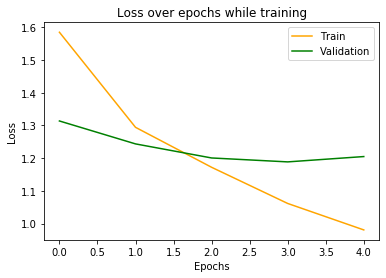

In [ ]:
Epochs = [0,1,2,3,4]
train_loss = [1.5848,1.2941,1.1719,1.0613,0.9804]
val_loss = [1.3135,1.2434,1.2004,1.1884,1.2047]
  

  
plt.plot(Epochs, train_loss, color ='orange', label ='Train')
  
plt.plot(Epochs, val_loss, color ='g', label ='Validation')
  
plt.xlabel('Epochs')
plt.ylabel('Loss')
  
plt.title('Loss over epochs while training')
  
plt.legend()
plt.show()